<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/ae(1_layer)_chip_adam1024_save_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
# from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install biopython
from Bio import SeqIO

     |████████████████████████████████| 2.3MB 10.8MB/s 


# Read Data

In [ ]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def readFasta(file):
  with open(file, 'r') as f:
    records = np.array([record.seq._data.upper() for record in SeqIO.parse(f, 'fasta')])
  with open(file, 'r') as f:
    records_id = np.array([record.id for record in SeqIO.parse(f, 'fasta')])
  print('reading', str(file), 'Number of sequences :', 
        len(records), 'Length of sequences :', len(records[0]))
  records_df = pd.DataFrame({'id': records_id, 'seq': records})
  return records_df

In [ ]:
# read fasta data
data_path = '/content/gdrive/My Drive/Colab Notebooks/CHIP/'
chip_train = readFasta(data_path + 'train.fasta')
chip_val = readFasta(data_path + 'valid.fasta')
chip_test = readFasta(data_path + 'test.fasta')
chip_train["id"] = chip_train["id"].astype(int)
chip_val["id"] = chip_val["id"].astype(int)
chip_test["id"] = chip_test["id"].astype(int)
print(chip_train.id.value_counts())
print(chip_val.id.value_counts())
print(chip_test.id.value_counts())

reading /content/gdrive/My Drive/Colab Notebooks/CHIP/train.fasta Number of sequences : 77174 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/valid.fasta Number of sequences : 1000 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/test.fasta Number of sequences : 19544 Length of sequences : 101
1    38638
0    38536
Name: id, dtype: int64
1    500
0    500
Name: id, dtype: int64
0    9823
1    9721
Name: id, dtype: int64


In [ ]:
seq_num = 0
for seq in chip_train["seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

In [ ]:
# check if the length of the sequence is the same 
seq_len = len(chip_train.seq[0])
print("The length of the sequence is", seq_len)
for seq in chip_train.seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 101


In [ ]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
vocab_size = len('ACGT')
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [ ]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [ ]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T') - 2

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 2, 1, 0])>

In [ ]:
BATCH_SIZE = 1024
xtrain_seq = tf.data.Dataset.from_tensor_slices(chip_train['seq']).map(index_preprocess).batch(BATCH_SIZE)
xval_seq = tf.data.Dataset.from_tensor_slices(chip_val['seq']).map(index_preprocess).batch(BATCH_SIZE)
xtest_seq = tf.data.Dataset.from_tensor_slices(chip_test['seq']).map(index_preprocess).batch(BATCH_SIZE)

In [ ]:
latent_size = 30

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(4, activation='softmax'))  # ACTG
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                10350     
_________________________________________________________________
sequential_1 (Sequential)    (None, 101, 4)            7444      
Total params: 17,794
Trainable params: 17,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# save_freq=1500 means that the model will be saved around every 20 epochs (each epochs contain 76 batches)
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/models/lstm1_chip.1024.{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=False,
    save_freq=1500)
es_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

In [ ]:
recurrent_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=3000, callbacks=[es_cb])

Epoch 1/3000
76/76 [==============================] - 14s 190ms/step - loss: 1.3664 - accuracy: 0.2991 - val_loss: 1.3506 - val_accuracy: 0.3247
Epoch 2/3000
76/76 [==============================] - 14s 183ms/step - loss: 1.3464 - accuracy: 0.3329 - val_loss: 1.3428 - val_accuracy: 0.3377
Epoch 3/3000
76/76 [==============================] - 14s 179ms/step - loss: 1.3428 - accuracy: 0.3381 - val_loss: 1.3422 - val_accuracy: 0.3382
Epoch 4/3000
76/76 [==============================] - 13s 175ms/step - loss: 1.3424 - accuracy: 0.3384 - val_loss: 1.3419 - val_accuracy: 0.3376
Epoch 5/3000
76/76 [==============================] - 13s 176ms/step - loss: 1.3421 - accuracy: 0.3386 - val_loss: 1.3417 - val_accuracy: 0.3381
Epoch 6/3000
76/76 [==============================] - 13s 176ms/step - loss: 1.3419 - accuracy: 0.3387 - val_loss: 1.3415 - val_accuracy: 0.3386
Epoch 7/3000
76/76 [==============================] - 13s 177ms/step - loss: 1.3418 - accuracy: 0.3388 - val_loss: 1.3413 - val_ac

In [ ]:
model_path = '/content/gdrive/My Drive/Colab Notebooks/models/'
recurrent_ae.save(model_path + 'ae(1)_chip_adam1024.h5')

In [ ]:
def save_hist():
  filename = data_path + "ae_chip_adam1024_reconstruction_history.csv"
  hist_df = pd.DataFrame(ae_hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()

In [ ]:
# # can continue training
# loaded_ae_model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/lstm1_chip.0030.h5')
# reconstructed_encoder = keras.Model(loaded_ae_model.layers[0].input, loaded_ae_model.layers[0].output)
# reconstructed_decoder = keras.Model(loaded_ae_model.layers[1].input, loaded_ae_model.layers[1].output)
# reconstructed_autoencoder = keras.Sequential([reconstructed_encoder, reconstructed_decoder])
# reconstructed_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# ae_hist2 = reconstructed_autoencoder.fit(xtrain_seq, validation_data=xval_seq, epochs=200, callbacks=[es_cb,model_checkpoint_callback])

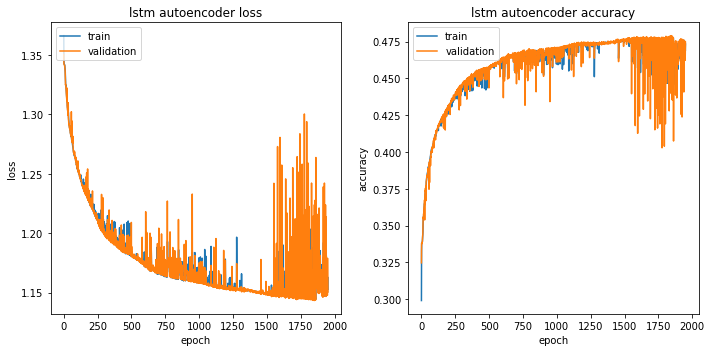

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
# # how to reconstruct the sequence
# idx_to_char = {'0':'T', '1':'G', '2':'C', '3':'A'}
# def show_reconstructions(model, x_seq=xtrain_seq, original_data=chip_train, samples=10):
#   reconstructions = model.predict(x_seq)
#   print('The shape of reconstructions', reconstructions.shape)
#   recon_softmax = np.argmax(reconstructions, axis=-1)
#   for i in range(samples):
#     seq = ''
#     for idx in recon_softmax[i]:
#       seq += idx_to_char[str(idx)]
#     print()
#     print('The {}-th original sequence vs after reconstruction'.format(i))
#     print(original_data['seq'].iloc[i])
#     print(seq)

# show_reconstructions(recurrent_ae, xval_seq, chip_val)

In [ ]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (77174, 30) (1000, 30) (19544, 30)


In [ ]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

In [ ]:
# # too many training example
# xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec[:1000])
# xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
# xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec[:1000])

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# plotVec(axes[0], xtrain_tsne, chip_train[:1000]["id"], title="TSNE, training")
# plotVec(axes[1], xval_tsne, chip_val["id"], title="TSNE, validation")
# plotVec(axes[2], xtest_tsne, chip_test[:1000]["id"], title="TSNE, test")
# fig.tight_layout()

In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"),    
  keras.layers.Dropout(0.2),
  keras.layers.Dense(32, activation="relu"),  
  keras.layers.Dropout(0.2), 
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),   
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model_hist = model.fit(xtrain_vec, chip_train['id'], validation_data=(xval_vec, chip_val['id']), epochs=1000, callbacks=[es_cb])

Epoch 1/1000
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6935 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/1000
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6930 - accuracy: 0.5090 - val_loss: 0.6912 - val_accuracy: 0.5500
Epoch 3/1000
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6915 - accuracy: 0.5237 - val_loss: 0.6898 - val_accuracy: 0.5440
Epoch 4/1000
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6893 - accuracy: 0.5356 - val_loss: 0.6897 - val_accuracy: 0.5410
Epoch 5/1000
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6873 - accuracy: 0.5480 - val_loss: 0.6868 - val_accuracy: 0.5510
Epoch 6/1000
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6861 - accuracy: 0.5505 - val_loss: 0.6817 - val_accuracy: 0.5610
Epoch 7/1000
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6852 - accuracy: 0.5530 - val_loss: 0.6838 -

In [ ]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [ ]:
eval_model(model, xtrain_vec, chip_train["id"], "Training")
eval_model(model, xval_vec, chip_val["id"], "Validation")
eval_model(model, xtest_vec, chip_test["id"], "Test")

Training Dataset: loss = 0.605 and acccuracy = 0.676
Validation Dataset: loss = 0.607 and acccuracy = 0.675
Test Dataset: loss = 0.616 and acccuracy = 0.665


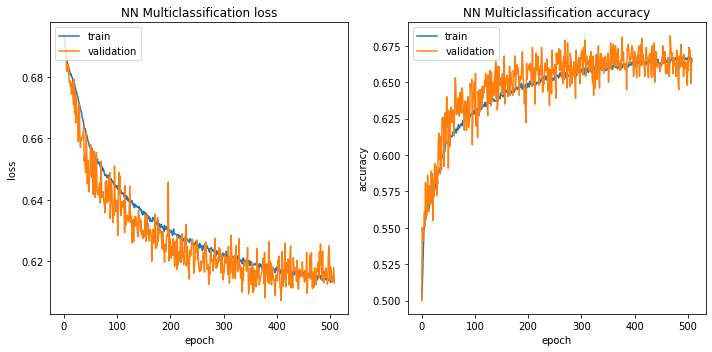

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
def save_hist():
  filename = data_path + "ae_chip_adam1024_prediction_history.csv"
  hist_df = pd.DataFrame(model_hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()